### Package import & function definition

In [105]:
while True:
    try:
        import pandas as pd
        from sys import argv
        from datetime import datetime
        import os
        import tkinter
        from tkinter import filedialog
        import pymysql
        import matplotlib as mpl
        import matplotlib.pyplot as plt
        import matplotlib.font_manager as fm
        #from pandasql import sqldf
        #from scipy.interpolate import make_interp_spline, BSpline
        break
    except: 
        !pip install pandas pymysql matplotlib 
                         #scipy pandasql

# Allow jupyter notebook to draw plots in inline
%matplotlib inline
# Enable retina display resolution options
%config InlineBackend.figure_format = 'retina'

mpl.rcParams['axes.unicode_minus'] = False
#fontprop = fm.FontProperties(fname='/Library/Fonts/Arial Unicode.ttf', size=18)
#fm._rebuild()
plt.rc('font', family='AppleGothic')

def logger(*args):
    """
        Print log message with excecuting file name, timestamp.
        *** All parameters should be on string-type!
    """
    try: __file__
    except NameError:
        message = f"[{str(datetime.now())}] {str(' '.join(args))}"
    else:
        message = f"[{__file__} {str(datetime.now())}] {str(' '.join(args))}"
    print(message)

def connectDB():
    """
       Connect to MySQL database server, returning connection & cursor objects. 
    """
    try:
        connection = pymysql.connect(host=keys.HOST, port=keys.PORT, 
                                    user=keys.USERNAME, password=keys.PASSWORD, 
                                    database=keys.DBNAME)
        cursor = connection.cursor()
        logger('DB connection Established.')
        return connection, cursor
    except Exception as e:
        msg = f'DB connection failed! ERROR: {str(e)}'
        logger(msg)

def askDialogue(question, statement, completeMessage=None, failureMessage=None):
    while True:
        userResponse = input(f'{str(question)} [y/n]\t').lower()
        if userResponse in ['yes', 'y', True]:
            statement
            if completeMessage != None:
                logger(f'{str(completeMessage)}')
            break
        elif userResponse in ['no', 'n', False]:
            if failureMessage != None:
                logger(f'{str(failureMessage)}')
            break
        else:
            print('Wrong response')

#pysqldf = lambda q: sqldf(q, globals())

currentPath = globals()['_dh'][0]

def getDframeName(df):
    name =[x for x in globals() if globals()[x] is df][0]
    return name

def saveDataframe(df, fileName=None): 
    if fileName == None: fileName = getDframeName(df)+'.csv'
    df.to_csv(fileName)
    logger(f"Dataframe saved as {fileName}")

logger("import & definition ends successfully.")

[2021-06-05 04:03:38.095028] import & definition ends successfully.


### Load data from database

In [21]:
import keys
connection, cursor = connectDB()

logger('Select data from db server...')
query = f"""SELECT stationName, measuredDatetime, PM25
            FROM `nifos`
            ORDER BY stationName ASC, measuredDatetime ASC"""
nifos = pd.read_sql(query, connection)
display(nifos)
print(nifos.dtypes)

separatorColumn, datetimeColumn, dataColumn = tuple(nifos.columns)

[2021-06-05 02:28:19.338438] DB connection Established.
[2021-06-05 02:28:19.357623] Select data from db server...


,stationName,measuredDatetime,PM25
0,고매_150m,2020-01-01 00:00:00,21.046167
1,고매_150m,2020-01-01 01:00:00,21.590833
2,고매_150m,2020-01-01 02:00:00,20.475167
3,고매_150m,2020-01-01 03:00:00,19.425167
4,고매_150m,2020-01-01 04:00:00,19.658167
...,...,...,...
218264,횡성_5m,2021-03-31 19:00:00,17.866667
218265,횡성_5m,2021-03-31 20:00:00,17.766667
218266,횡성_5m,2021-03-31 21:00:00,15.783333
218267,횡성_5m,2021-03-31 22:00:00,14.566667


stationName                 object
measuredDatetime    datetime64[ns]
PM25                       float64
dtype: object


### Filter data which are available for winter 2020 and 2021

In [69]:
targetStation = tuple(nifos[nifos[datetimeColumn].dt.strftime('%Y%m') == '202001'][separatorColumn].unique())
logger(f"targetStation: {str(targetStation)}")
nifos_filtered = nifos.query(f"{separatorColumn} == {targetStation}")[nifos[datetimeColumn].dt.month <= 3]
display(nifos_filtered)

[2021-06-05 03:24:14.074271] targetStation: ('고매_150m', '고매_도로', '시화_산단', '시화_주거', '시화_차단숲', '양재_200m', '양재_300m', '양재_도로', '홍릉_도심', '홍릉_숲내부5m', '홍릉_숲외부20m')


,stationName,measuredDatetime,PM25
0,고매_150m,2020-01-01 00:00:00,21.046167
1,고매_150m,2020-01-01 01:00:00,21.590833
2,고매_150m,2020-01-01 02:00:00,20.475167
3,고매_150m,2020-01-01 03:00:00,19.425167
4,고매_150m,2020-01-01 04:00:00,19.658167
...,...,...,...
213737,홍릉_숲외부20m,2021-03-31 19:00:00,14.000000
213738,홍릉_숲외부20m,2021-03-31 20:00:00,14.966667
213739,홍릉_숲외부20m,2021-03-31 21:00:00,17.400000
213740,홍릉_숲외부20m,2021-03-31 22:00:00,18.100000


### Make boxplot with filtered data

[2021-06-05 03:45:22.761007] Plot saved as 2020 & 2021년 1~3월 PM25 데이터 분포


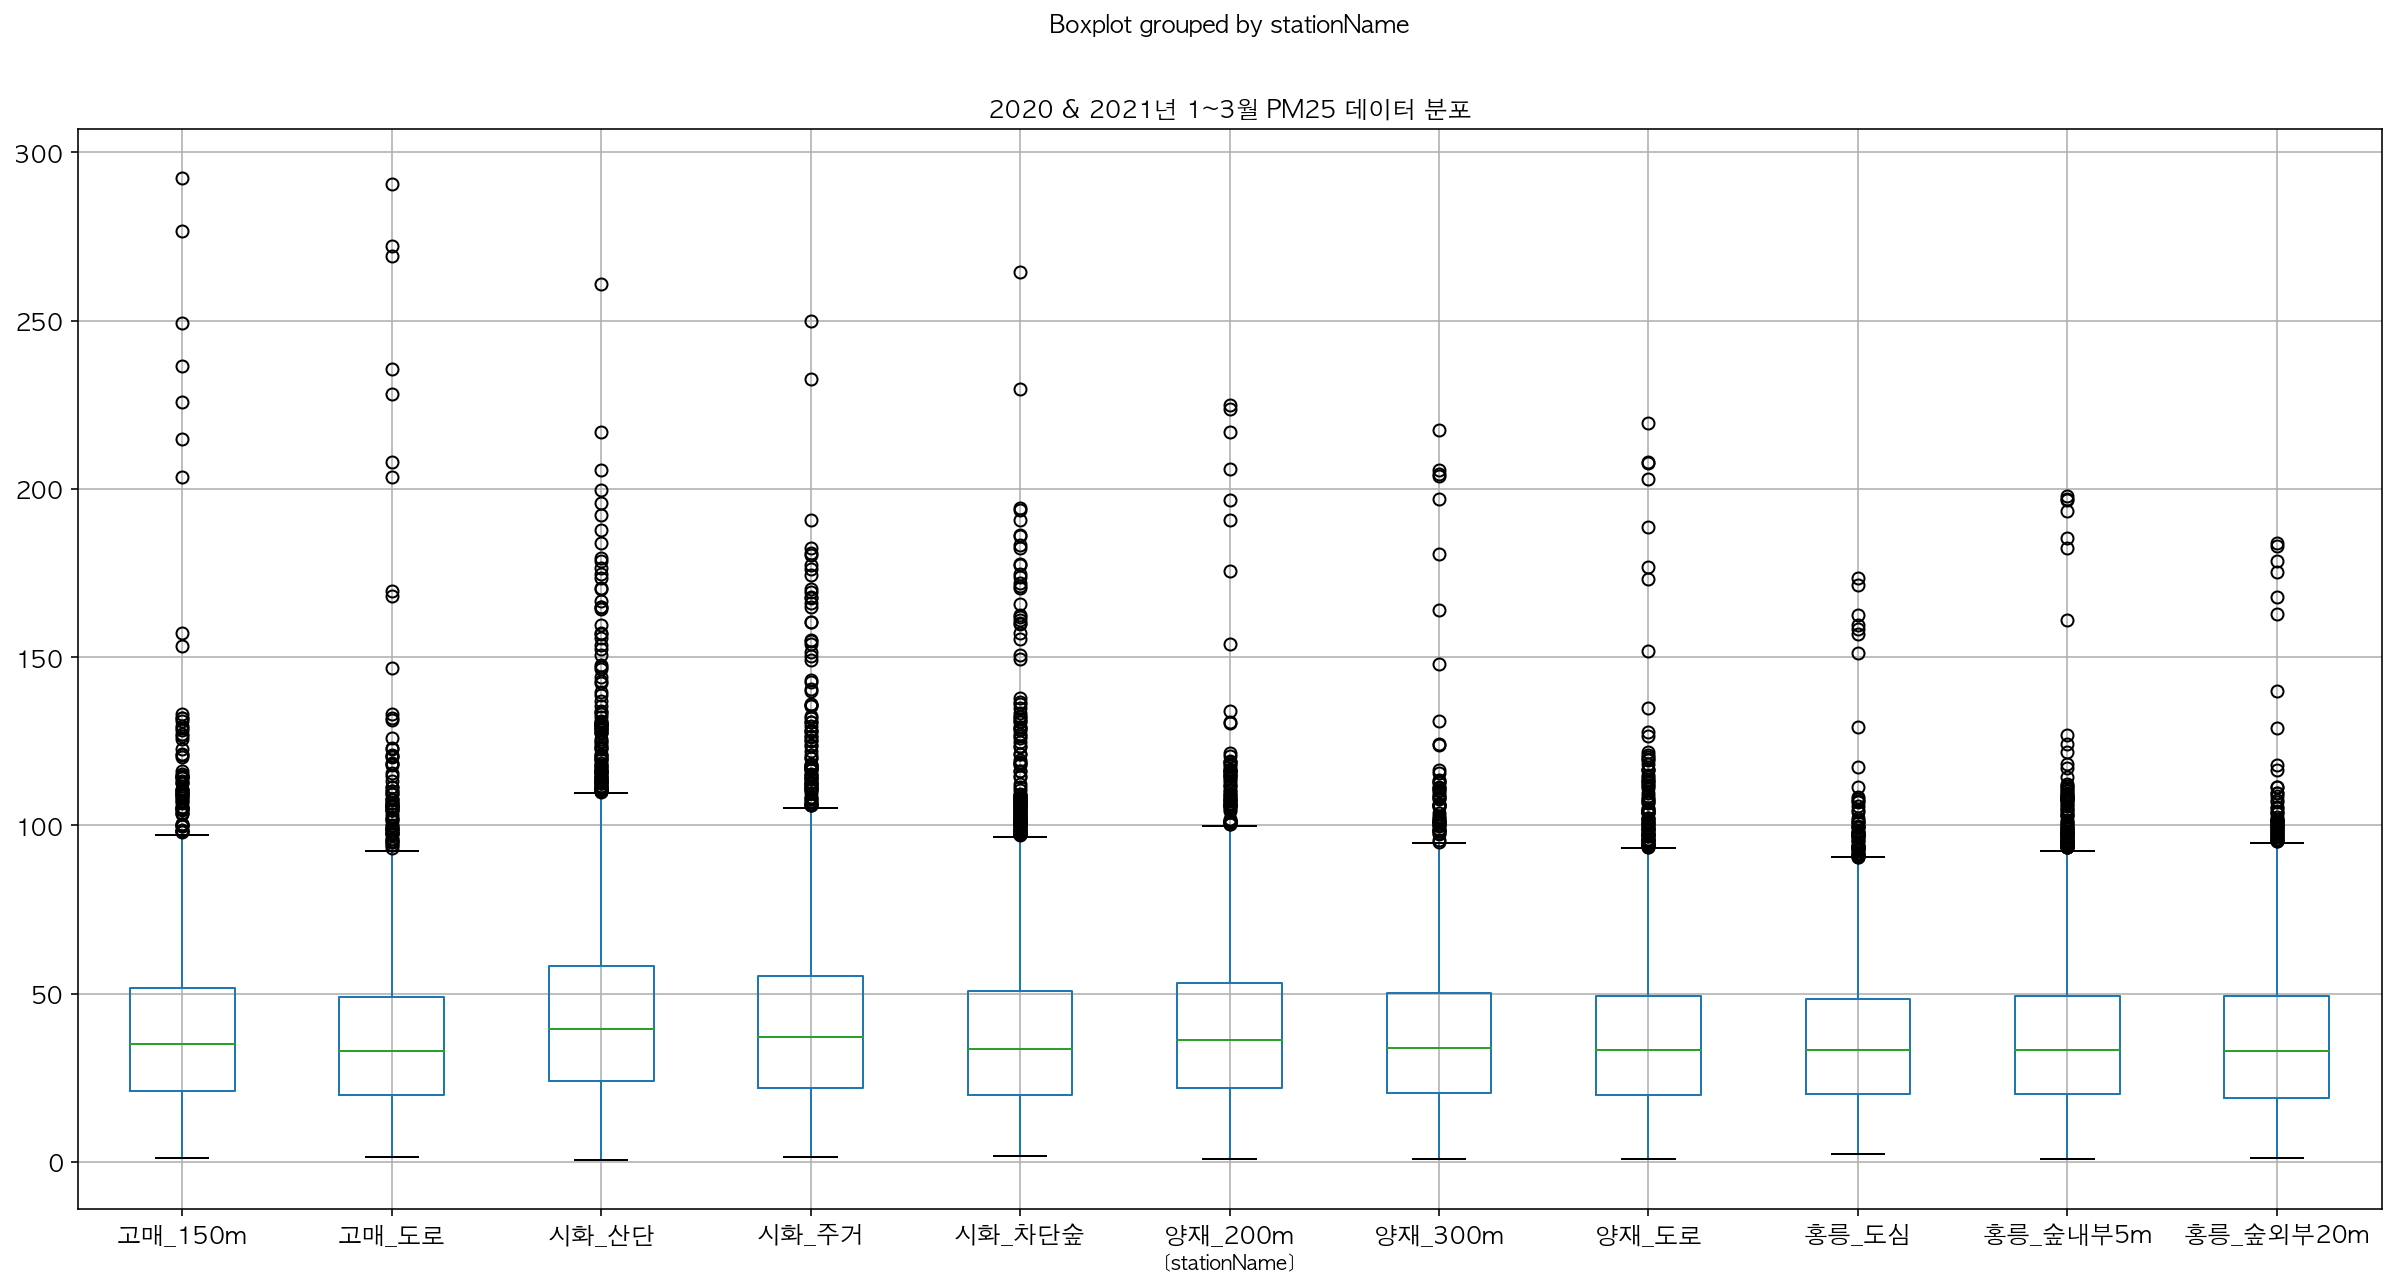

In [88]:
nifosPlot = nifos_filtered[[separatorColumn, dataColumn]].boxplot(by=separatorColumn, figsize=(20, 10), fontsize='large')
plotTitle = f'2020 & 2021년 1~3월 {dataColumn} 데이터 분포'
nifosPlot.set_title(plotTitle)
plt.savefig(plotTitle+'.png')
logger(f"Plot saved as {plotTitle}")

### Filtered data's summary between Jan to Mar

In [106]:
nifos_filtered_summary = nifos_filtered.groupby(separatorColumn)[dataColumn].agg(['mean', 'median', 'max']).round(3)
display(nifos_filtered_summary)
saveDataframe(nifos_filtered_summary)

,mean,median,max
stationName,,,
고매_150m,38.780,34.967,292.500
고매_도로,36.920,33.067,290.700
시화_산단,44.788,39.453,260.990
시화_주거,41.909,37.150,250.033
시화_차단숲,39.292,33.692,264.335
양재_200m,40.543,36.322,225.083
양재_300m,37.947,33.937,217.433
양재_도로,37.681,33.158,219.490
홍릉_도심,36.522,33.241,173.417


[2021-06-05 04:03:53.490598] Dataframe saved as nifos_filtered_summary.csv


### Filtered data's montly summary between jan to mar

In [110]:
nifos_filtered_monthly = nifos_filtered.groupby([separatorColumn, nifos_filtered[datetimeColumn].dt.month ]).agg(['mean', 'median', 'max']).round(3)#.reset_index()
display(nifos_filtered_monthly)
saveDataframe(nifos_filtered_monthly)

PM25                 
                                mean  median      max
stationName measuredDatetime                         
고매_150m     1                 35.151  32.181   99.714
            2                 38.325  31.124  114.828
            3                 42.698  40.292  292.500
고매_도로       1                 33.538  30.611   99.883
            2                 36.673  29.760  146.750
            3                 40.531  37.964  290.700
시화_산단       1                 40.137  39.538  111.650
            2                 43.656  35.737  159.575
            3                 50.416  43.192  260.990
시화_주거       1                 37.862  37.241   97.300
            2                 40.740  33.010  164.817
            3                 46.864  40.400  250.033
시화_차단숲      1                 33.061  31.975   94.057
            2                 38.225  30.120  160.983
            3                 46.813  40.020  264.335
양재_200m     1                 35.977  32.767  101.354
            2                 40.744  33.260  120.497
            3                 43.955  41.146  225.083
양재_300m     1                 33.425  30.418   94.700
            2                 38.855  31.200  130.971
            3                 40.738  37.915  217.433
양재_도로       1                 33.188  29.900   97.453
            2                 37.550  30.000  121.740
            3                 41.307  38.017  219.490
홍릉_도심       1                 33.836  32.380   97.000
            2                 37.049  30.808  108.439
            3                 38.625  35.712  173.417
홍릉_숲내부5m    1                 33.738  31.194  109.127
            2                 38.214  29.517  112.183
            3                 41.325  37.267  197.900
홍릉_숲외부20m   1                 33.517  30.798  101.633
            2                 37.577  31.162  116.461
            3                 38.545  35.720  183.850

[2021-06-05 04:06:35.845175] Dataframe saved as nifos_filtered_monthly.csv
